# Language detection
Make a model that can classify language used in a text.

Use ngrams technique (see `nltk`) to preprocess text, and then compute a bag of words (see `CountVectorizer` from sklearn) from these ngrams.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import re
import string
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
#Const
RANDOM_SEED = 176
#Import dataset
URL = "https://raw.githubusercontent.com/ProfAI/natural-language-processing/refs/heads/main/datasets/Lezione_4-language_detection/dataset.csv"
df = pd.read_csv(URL)
df.head()


,Text,language
0,klement gottwaldi surnukeha palsameeriti ning ...,Estonian
1,sebes joseph pereira thomas på eng the jesuit...,Swedish
2,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...,Thai
3,விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...,Tamil
4,de spons behoort tot het geslacht haliclona en...,Dutch


## Data exploration
Check on target (i.e. language column) distribution

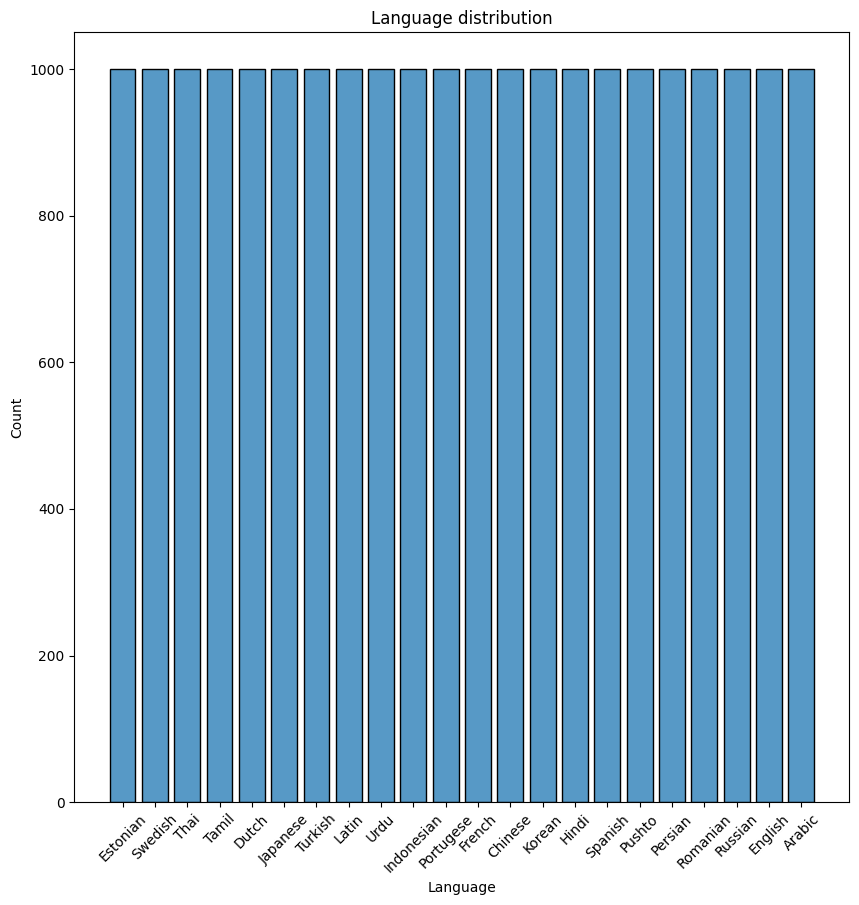

In [3]:
plt.figure(figsize=(10,10))
sns.histplot(data=df, x="language", discrete=True, shrink=0.8)
plt.xlabel("Language")
plt.xticks(rotation=45)
plt.title("Language distribution")
plt.show()

The dataset is perfectly balanced.

How many languages are tehere in the dataset?

In [4]:
n_languages = len(np.unique(df["language"]))
print(f"There are {n_languages} languages provided")

There are 22 languages provided


## Text cleaning
Text is cleaned via a custom function, where these steps are performed:
- lowecase
- remove punctuation
- remove numbers
- replace multiple spaces with single space

In [5]:
def text_cleaning(sentence):
    """
    Clean a text string.
    There are no stopwords since it isn't suitable for language detection.
    """
    #lowercase
    sentence=sentence.lower()
    #remove punctuation
    for c in string.punctuation:
        sentence = sentence.replace(c,"")
    #numbers
    sentence = re.sub(r"\d", "",sentence)
    #trailing spaces
    sentence = re.sub(r" +", " ",sentence)
    return sentence

In [6]:
df["clean_text"] = df["Text"].apply(text_cleaning)
df.head()

,Text,language,clean_text
0,klement gottwaldi surnukeha palsameeriti ning ...,Estonian,klement gottwaldi surnukeha palsameeriti ning ...
1,sebes joseph pereira thomas på eng the jesuit...,Swedish,sebes joseph pereira thomas på eng the jesuits...
2,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...,Thai,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...
3,விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...,Tamil,விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...
4,de spons behoort tot het geslacht haliclona en...,Dutch,de spons behoort tot het geslacht haliclona en...


## n-grams
Compute n-grams through nltk `ngrams` function, wrapped in a custom function.

In [7]:
def compute_ngrams(sentence, n=2):
  """
  Compute the n-grams for the given sentence.
  """
  tmp_tuple = ngrams(sentence, n) #tuple
  tmp_string = ["".join(ngr) for ngr in tmp_tuple] #ngrams list (list of strings)
  return " ".join(tmp_string) #string of ngrams concatenation

In [8]:
#check
compute_ngrams("Frase di prova")

'Fr ra as se e   d di i   p pr ro ov va'

In [9]:
df["ngrams_text"] = df["clean_text"].apply(compute_ngrams)
df.head()

,Text,language,clean_text,ngrams_text
0,klement gottwaldi surnukeha palsameeriti ning ...,Estonian,klement gottwaldi surnukeha palsameeriti ning ...,kl le em me en nt t g go ot tt tw wa al ld d...
1,sebes joseph pereira thomas på eng the jesuit...,Swedish,sebes joseph pereira thomas på eng the jesuits...,se eb be es s j jo os se ep ph h p pe er r...
2,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...,Thai,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...,ถน นน นเ เจ จร ริ ิญ ญก กร รุ ุง ง อ อั ัก ก...
3,விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...,Tamil,விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...,வி ிச சா ாக கப ப் ்ப பட ட் ்ட டி ின னம ம் ் ...
4,de spons behoort tot het geslacht haliclona en...,Dutch,de spons behoort tot het geslacht haliclona en...,de e s sp po on ns s b be eh ho oo or rt t...


## Train test split
before preprocessing, let's split the dataset into train and test.

Note: the `stratify` argument is used in order to keep the original target distribution.

In [10]:
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df["language"], random_state=RANDOM_SEED)

#check
print(df_train.shape)
print(df_test.shape)

(17600, 4)
(4400, 4)


## Bag of words
Text vectorization is computed with a bag of words of the n-grams (`df["ngrams_text"]`).

Here the `CountVectorizer` is used.

In [11]:
vectorizer = CountVectorizer(min_df = 0.04)
X_train = vectorizer.fit_transform(df_train["ngrams_text"]).toarray()
X_test = vectorizer.transform(df_test["ngrams_text"]).toarray()
y_train = df_train["language"].values
y_test = df_test["language"].values

#check
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(17600, 425)
(4400, 425)
(17600,)
(4400,)


## Label encoding
Since target is a string, it cannot be used directly with ML model.

It must be encoded in numbers, and here the sklearn `LabelEncoder` is used.

In [12]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

## Model
The ML model here is a multilayer perceptron, implemented with keras.



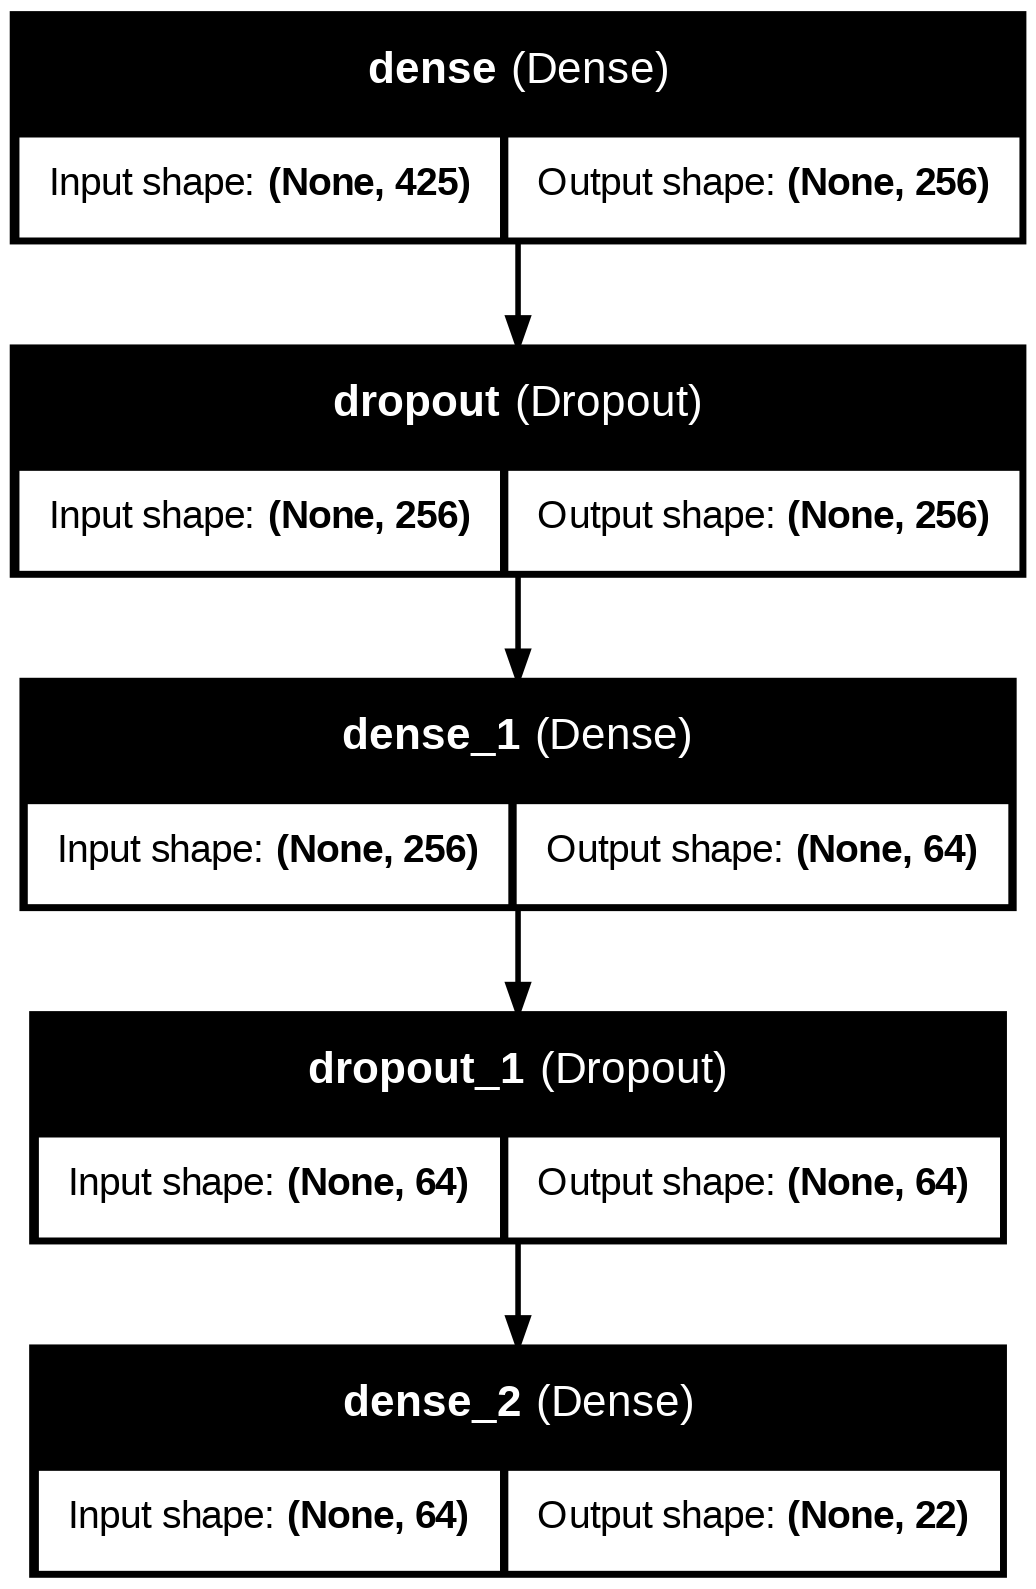

In [13]:
clear_session()

model = Sequential()
model.add(InputLayer(shape=(len(vectorizer.vocabulary_),)))
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(n_languages, activation='softmax'))

plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)

In [14]:
model.compile(optimizer='adam',loss = "sparse_categorical_crossentropy", metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         109,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 22)                  │           1,430 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 126,934 (495.84 KB)

 Trainable params: 126,934 (495.84 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
callback = EarlyStopping(verbose=1,monitor='val_loss',restore_best_weights=False, patience=5)
history = model.fit(X_train, y_train, epochs=100, callbacks=[callback], batch_size=32, validation_split=0.25)

Epoch 1/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4415 - loss: 1.9789 - val_accuracy: 0.7518 - val_loss: 0.6913
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7297 - loss: 0.7512 - val_accuracy: 0.7536 - val_loss: 0.6304
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7481 - loss: 0.6561 - val_accuracy: 0.7648 - val_loss: 0.6148
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7522 - loss: 0.6182 - val_accuracy: 0.7564 - val_loss: 0.6154
Epoch 5/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7553 - loss: 0.5964 - val_accuracy: 0.7655 - val_loss: 0.6060
Epoch 6/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7660 - loss: 0.5666 - val_accuracy: 0.7677 - val_loss: 0.6038
Epoch 7/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7735 - loss: 0.5502 - val_accuracy: 0.7709 - val_loss: 0.6092
Epoch 8/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7752 - loss: 0.5503 - val_accu

## Fit evaluation
Let's plot the learning curve as a check, and make a `classification_report`, using test data.

In [16]:
def plot_learning_curve(history):
    plt.figure(figsize=(16,10))
    plt.subplot(2,1,1)
    plt.plot(history.history["loss"], label= "train")
    plt.plot(history.history["val_loss"], label = "valid")
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("Loss")
    plt.subplot(2,1,2)
    # plt.plot(np.mean(history.history["accuracy"],axis=1), label="train")
    # plt.plot(np.mean(history.history["val_accuracy"],axis=1), label = "valid")
    plt.plot(history.history["accuracy"], label="train")
    plt.plot(history.history["val_accuracy"], label = "valid")
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("Accuracy")
    plt.show()

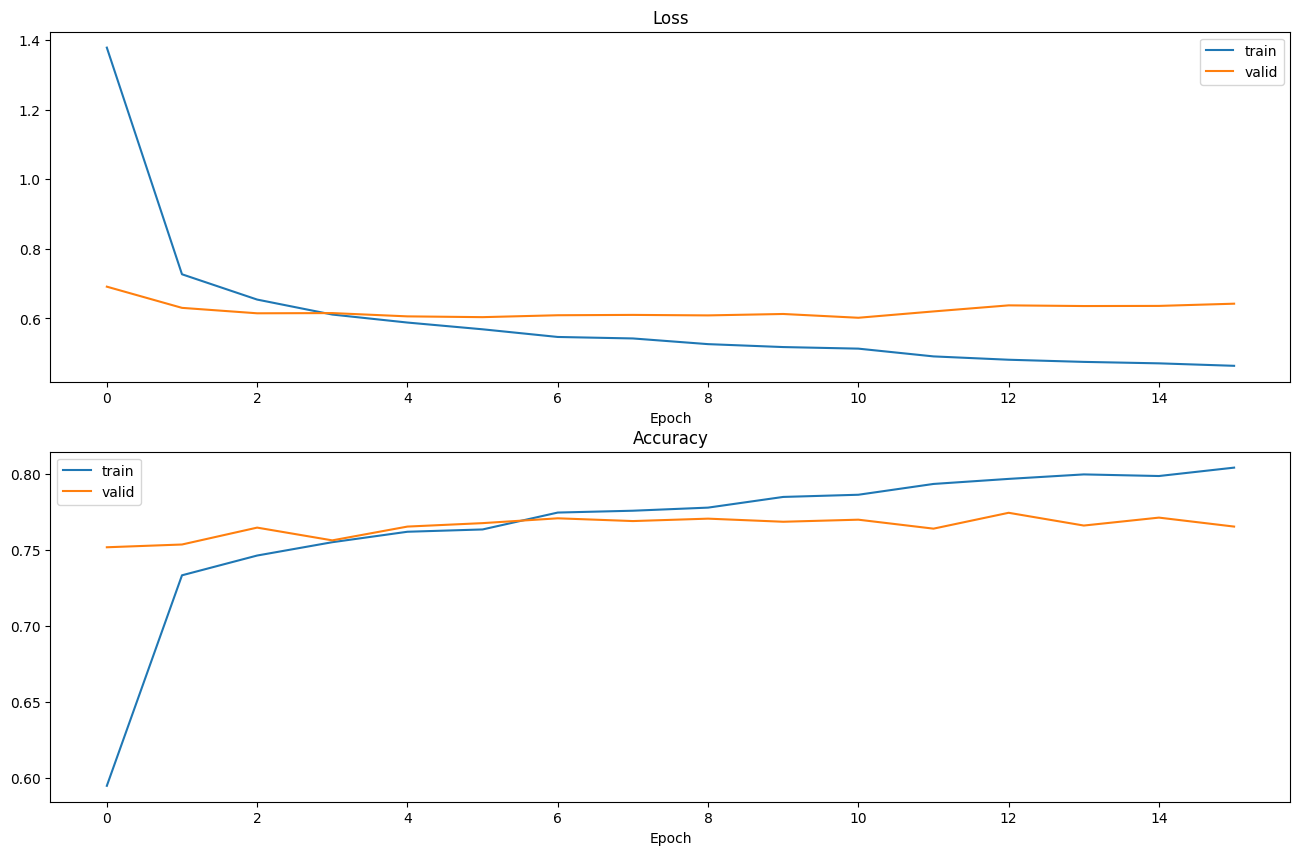

In [17]:
plot_learning_curve(history)

In [20]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1) # Convert probabilities to class labels
# print(classification_report(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

      Arabic       1.00      1.00      1.00       200
     Chinese       0.36      0.14      0.21       200
       Dutch       0.98      0.99      0.99       200
     English       0.84      0.96      0.90       200
    Estonian       0.99      0.94      0.97       200
      French       0.96      0.95      0.96       200
       Hindi       0.31      0.06      0.09       200
  Indonesian       1.00      0.98      0.99       200
    Japanese       0.36      0.14      0.20       200
      Korean       0.39      0.06      0.10       200
       Latin       0.91      0.94      0.93       200
     Persian       0.99      0.99      0.99       200
   Portugese       0.94      0.92      0.93       200
      Pushto       0.97      0.97      0.97       200
    Romanian       0.96      0.96      0.96       200
     Russian       0.98      0.98      0.98       200
     Spanish       0.95      0.97      0

There are some issues with asiatic languages like chinese, thai and korean, but accuracy is good ($76\%$).